

## **Cultivating a Greener Future: Unearthing Sustainable Farming Practices Amidst Climate Change and Pesticide Challenges**

##### by By Osamudiamen Igbinidun and Nicholas Abram
##### University of Michigan, SIADS 593 Milestone I, MADS

## Background

### Pesticide Use and Environmental Impact

Pesticides have played a significant role in agricultural development, providing a means to control pests and diseases that can damage crops[^1^]. However, their widespread use has also led to various environmental and health concerns. Pesticide contamination of soil, water, turf, and other vegetation has become a widespread problem, with groundwater pollution being particularly concerning[^4^]. In developing countries, the use of pesticides has been linked to negative impacts on human health and food security[^5^].

### Sustainable Farming Practices

As the global community becomes more aware of the environmental and health risks associated with pesticide use, there is a growing interest in sustainable farming practices that can reduce dependence on these chemicals[^3^]. Some developed countries, such as Denmark, France, Finland, and Japan, have already taken steps to reduce pesticide use intensity in recent years[^2^]. These efforts highlight the potential for alternative approaches to boost crop yields without increasing pesticide use.

### Climate Change and Pesticide Use

Climate change-related factors, such as temperature and rainfall, can also influence pesticide use and its adverse effects on the natural environment[^1^]. As weather conditions become more unpredictable, it is crucial to understand how these factors interact with pesticide use and farm productivity. This understanding can help inform the development of more sustainable agricultural practices that are resilient to changing climate conditions.

### A Roadmap for Sustainable Agriculture

In an era where food security and environmental health are intertwined, it is essential to find ways to reduce our dependence on pesticides and promote sustainable farming practices[^3^]. By studying countries that have successfully raised crop output while stabilizing or reducing pesticide use, we can uncover methods for better sustainable farming and provide insights that can be applied globally. Our future endeavor would be to create a roadmap for agricultural practices that nurture the land and its inhabitants while highlighting the value of sustainable farming in the context of food security and environmental health.

## Research Questions

#### Question 1: Which countries have successfully raised crop output while stabilizing or reducing pesticide use?

This question aims to identify countries that have managed to boost their agricultural productivity without increasing their reliance on pesticides. By examining these nations, you can uncover the strategies and practices they have implemented to achieve sustainable farming.

#### Question 2: How do weather conditions, like temperature and rainfall, influence farm productivity and pesticide use?

Understanding the role of climate factors in the link between farm productivity and pesticide use is crucial for developing sustainable agricultural practices that are resilient to changing weather conditions. This question seeks to explore the impact of temperature and rainfall on the effectiveness of various farming methods and their reliance on pesticides.

# Import libraries

In [1]:
import requests
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import display, Markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Sources

The `yield.csv` dataset has the following properties:

- **Location**: The dataset was downloaded from FAOSTAT, specifically from the URL: [Production_Crops_Livestock_E_All_Data_(Normalized).zip](https://fenixservices.fao.org/faostat/static/bulkdownloads/Production_Crops_Livestock_E_All_Data_(Normalized).zip).
- **Format**: The dataset is in CSV format.
- **Important Variables**: 
  - `Country`: The country for which the data is reported.
  - `Year`: The year in which the data was reported.
  - `Yield`: The yield value for the reported year and country.
- **Number of Records**: There are 13,547 records in the dataset.
- **Time Period**: The dataset covers the years from 1961 to 2021.

The `rainfall.csv` dataset has the following properties:

- **Location**: This dataset was sourced from the "Crop Yield Prediction Dataset" on Kaggle, available at the URL: [Crop Yield Prediction Dataset](https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset/data).
- **Format**: The dataset is in CSV format.
- **Important Variables**:
  - ` Area`: The area (likely country or region) for which the data is reported.
  - `Year`: The year in which the data was reported.
  - `average_rain_fall_mm_per_year`: The average rainfall in millimeters for the reported year and area.
- **Number of Records**: There are 6,727 records in the dataset.
- **Time Period**: The dataset covers the years from 1985 to 2017.

From the `temp.csv` dataset, we can observe:

- The column representing the year is named `year` instead of `Year`.
- The dataset contains columns for `country` and `avg_temp` which represent the country for which the data is reported and the average temperature respectively.

The `pest.csv` dataset has the following properties:

- **Location**: This dataset was also obtained from FAOSTAT, specifically from the URL: [Inputs_Pesticides_Use_E_All_Data_(Normalized).zip](https://fenixservices.fao.org/faostat/static/bulkdownloads/Inputs_Pesticides_Use_E_All_Data_(Normalized).zip).
- **Format**: The dataset is in CSV format.
- **Important Variables**:
  - `Country`: The country for which the data is reported.
  - `Year`: The year in which the data was reported.
  - `Pesticides`: The amount of pesticides used for the reported year and country.
- **Number of Records**: There are 112,350 records in the dataset.
- **Time Period**: The dataset covers the years from 1990 to 2021.

The `temp.csv` dataset has the following properties:

- **Location**: This dataset was also sourced from the "Crop Yield Prediction Dataset" on Kaggle, available at the URL: [Crop Yield Prediction Dataset](https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset/data).
- **Format**: The dataset is in CSV format.
- **Important Variables**:
  - `country`: The country for which the data is reported.
  - `year`: The year in which the data was reported.
  - `avg_temp`: The average temperature for the reported year and country.
- **Number of Records**: There are 71,311 records in the dataset.
- **Time Period**: The dataset covers the years from 1743 to 2013.

In [2]:
yield_url = 'https://fenixservices.fao.org/faostat/static/bulkdownloads/Production_Crops_Livestock_E_All_Data_(Normalized).zip'
pest_url = 'https://fenixservices.fao.org/faostat/static/bulkdownloads/Inputs_Pesticides_Use_E_All_Data_(Normalized).zip'

response = requests.get(yield_url)
zip_file = ZipFile(BytesIO(response.content))
csv_file = 'Production_Crops_Livestock_E_All_Data_(Normalized).csv'
yield_df = pd.read_csv(zip_file.open(csv_file), encoding='ISO-8859-1')

response = requests.get(pest_url)
zip_file = ZipFile(BytesIO(response.content))
csv_file = 'Inputs_Pesticides_Use_E_All_Data_(Normalized).csv'
pest_df = pd.read_csv(zip_file.open(csv_file), encoding='ISO-8859-1')

rain_df = pd.read_csv('./data/rainfall.csv')
temp_df = pd.read_csv('./data/temp.csv')

In [3]:
# Save for later use
yield_df.to_csv('yield.csv')
pest_df.to_csv('pest.csv')

# Explore Datasets

In [5]:
# Function to print various data attributes
def print_info(df, name):
    # display(Markdown(f'### **{name}**'))
    display(Markdown('**Dataframe info:**'))
    print(df.info())
    print('\n')
    display(Markdown('**Number of unique values per column:**'))
    print(df.nunique())
    print('\n')
    display(Markdown('**Summary statistics per column:**'))
    print(df.describe().round(0).astype(int))
    print('\n')

    display(Markdown('**Columns with missing values in df:**'))
    missing_values = df.isna().sum()
    print(missing_values[missing_values > 0].to_string(header=False))
    print('\n')

### Temperature Data (temp.csv)

In [6]:
print_info(temp_df, 'temp_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None




**Number of unique values per column:**

year         271
country      137
avg_temp    3303
dtype: int64




**Summary statistics per column:**

        year  avg_temp
count  71311     68764
mean    1906        16
std       67         8
min     1743       -14
25%     1858        10
50%     1910        16
75%     1962        24
max     2013        31




**Columns with missing values in df:**

avg_temp    2547




### Rainfall Data (rainfall.csv)

In [7]:
print_info(rain_df, 'rain_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0    Area                          6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.8+ KB
None




**Number of unique values per column:**

 Area                            217
Year                              31
average_rain_fall_mm_per_year    173
dtype: int64




**Summary statistics per column:**

       Year
count  6727
mean   2001
std      10
min    1985
25%    1993
50%    2001
75%    2010
max    2017




**Columns with missing values in df:**

average_rain_fall_mm_per_year    774




### Pesticides Data (pest.csv)

In [8]:
print_info(pest_df, 'pest_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112350 entries, 0 to 112349
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Area Code        112350 non-null  int64  
 1   Area Code (M49)  112350 non-null  object 
 2   Area             112350 non-null  object 
 3   Item Code        112350 non-null  int64  
 4   Item             112350 non-null  object 
 5   Element Code     112350 non-null  int64  
 6   Element          112350 non-null  object 
 7   Year Code        112350 non-null  int64  
 8   Year             112350 non-null  int64  
 9   Unit             112350 non-null  object 
 10  Value            112350 non-null  float64
 11  Flag             112350 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 10.3+ MB
None




**Number of unique values per column:**

Area Code            254
Area Code (M49)      254
Area                 254
Item Code             47
Item                  47
Element Code           4
Element                4
Year Code             32
Year                  32
Unit                   4
Value              33890
Flag                   4
dtype: int64




**Summary statistics per column:**

       Area Code  Item Code  Element Code  Year Code    Year    Value
count     112350     112350        112350     112350  112350   112350
mean         804       1338          5159       2006    2006     6569
std         1760         17             5          9       9    65038
min            1       1309          5157       1990    1990        0
25%           74       1321          5157       1998    1998        0
50%          147       1341          5157       2006    2006        8
75%          217       1357          5157       2014    2014      270
max         5817       1357          5173       2021    2021  3535375




**Columns with missing values in df:**

Series([], )




### Crop Yield Data (yield.csv)

In [9]:
print_info(yield_df, 'yield_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761168 entries, 0 to 3761167
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Area Code        int64  
 1   Area Code (M49)  object 
 2   Area             object 
 3   Item Code        int64  
 4   Item Code (CPC)  object 
 5   Item             object 
 6   Element Code     int64  
 7   Element          object 
 8   Year Code        int64  
 9   Year             int64  
 10  Unit             object 
 11  Value            float64
 12  Flag             object 
dtypes: float64(1), int64(5), object(7)
memory usage: 373.0+ MB
None




**Number of unique values per column:**

Area Code             245
Area Code (M49)       245
Area                  245
Item Code             301
Item Code (CPC)       301
Item                  301
Element Code           18
Element                 9
Year Code              61
Year                   61
Unit                   12
Value              941901
Flag                    5
dtype: int64




**Summary statistics per column:**

       Area Code  Item Code  Element Code  Year Code     Year       Value
count    3761168    3761168       3761168    3761168  3761168     3761168
mean        1487        830          5409       1994     1994     2477943
std         2304       1165           103         17       17    27727895
min            1         15          5111       1961     1961           0
25%           89        339          5312       1979     1979        2600
50%          170        600          5419       1995     1995       23164
75%         5000       1058          5510       2008     2008      156153
max         5817      17530          5513       2021     2021 -2147483648




**Columns with missing values in df:**

Series([], )




# Data Manipulation

## Column Transformations

There are some inconsistences in the nammes of the columns among the datasets. We renamed several of the columns for consistency and also to match on during merge of the data into a single dataframe. We also subset the data to keep only the columns of interest. 

On review of yield, rainfall, and pesticide data, they use area because it also includes data rows on larger areas than a country, for example, by hemisphere  or by continent. We will keep only the rows that deal directly with Country related data. Also, as demonstrated later, the data for some countries has multiple duplicates, which likely represent finer grained data from some of the larger countries. 

We subset each of the dataframes to include only the columns of interest to our analysis. 

The yield dataset contains information on individual crops, for our analysis we will combine these and sum the totals for that country by year. Based on the metadata for the dataset from the FAO, the code 5419 has to do with crop yields, we filtered for rows based on this code. The other codes deal with other farming products such as livestock and crop processing that are not relevant to our analysis. We then combine the crop yields for different crops into a single value by aggregating the sum of all crops for a Country.

In [10]:
temp_df.rename(columns = {'year':'Year','country':'Country','avg_temp':'Temperature'},inplace = True)
rain_df.rename(columns = {' Area':'Country','average_rain_fall_mm_per_year':'Rainfall'},inplace = True)
yield_df.rename(columns = {'Area':'Country','Value':'Yield'},inplace = True)
pest_df.rename(columns = {'Area':'Country','Value':'Pesticides'},inplace = True)

pest_df = pest_df[['Country', 'Year', 'Pesticides']]
yield_df = yield_df[['Country', 'Item', 'Year', 'Yield', 'Element Code']]

In [11]:
yield_df = yield_df[yield_df['Element Code'] == 5419].groupby(['Country','Year'])['Yield'].sum().reset_index()

## Data Integrity Findings

### Year Ranges

In [12]:
def year_ranges():
    print(f"Year range in temp.csv {temp_df['Year'].min()} - {temp_df['Year'].max()}")
    print(f"Year range in rainfall.csv {rain_df['Year'].min()} - {rain_df['Year'].max()}")
    print(f"Year range in yield.csv {yield_df['Year'].min()} - {yield_df['Year'].max()}")
    print(f"Year range in pesticides.csv {pest_df['Year'].min()} - {pest_df['Year'].max()}")

year_ranges()

Year range in temp.csv 1743 - 2013
Year range in rainfall.csv 1985 - 2017
Year range in yield.csv 1961 - 2021
Year range in pesticides.csv 1990 - 2021


### Country Name Inconsistencies
The country names between the pesticides and yield datasets have some inconsistencies, we can view the values that are present in the yield dataset but not in the pesticide dataset. As we can see there are several that don't make sense, such as Netherlands, United Kingdom, and Turkey. On review of the countries in the pesticides dataset, we note that 'Türkiye', 'United Kingdom of Great Britain and Northern Ireland', and 'Netherlands (Kingdom of the)' are listed. 

In [13]:
unique_values_yield = yield_df.loc[~yield_df['Country'].isin(pest_df['Country']), 'Country'].unique()
unique_values_yield

array(['Afghanistan', 'Dominica', 'Guadeloupe', 'Guyana',
       'Marshall Islands', 'Martinique', 'Micronesia', 'Netherlands',
       'Puerto Rico', 'Réunion', 'Singapore', 'South Sudan',
       'United Arab Emirates', 'Uzbekistan'], dtype=object)

In [14]:
replacements = {
    'Türkiye': 'Turkey',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Netherlands (Kingdom of the)':'Netherlands'
}

pest_df['Country'] = pest_df['Country'].replace(replacements)

### Missing Values
Both the rainfall and temp datasets have missing values, and we will need to explore these datasets further to understand why these data are missing, whether they are missing completely at random, missing at random, or not at random. Is there some pattern or reason that they may be missing? With these types of datasets, given the time frame on the rainfall and temperature datasets, data may not be available due to the time frame; likely, it was never collected or not available that long ago. Also, given that we are looking at data by country, some countries may not report their data. We suspect some values may be missing at random, but we believe it's more likely due to the aforementioned systemically missing values. Let's investigate.  

#### Temperature
We hypothesize that the missing values might be systematically absent or unavailable for specific time periods. To delve deeper into this, we'll employ the Altair visualization library to plot the frequency of these missing values and identify potential concentrations. Given the extensive range of years in this dataset, we've opted to group them into bins for a clearer visualization. Grouping the data in 10-year intervals strikes a balance between granularity and clarity, enabling us to pinpoint where values may be absent.

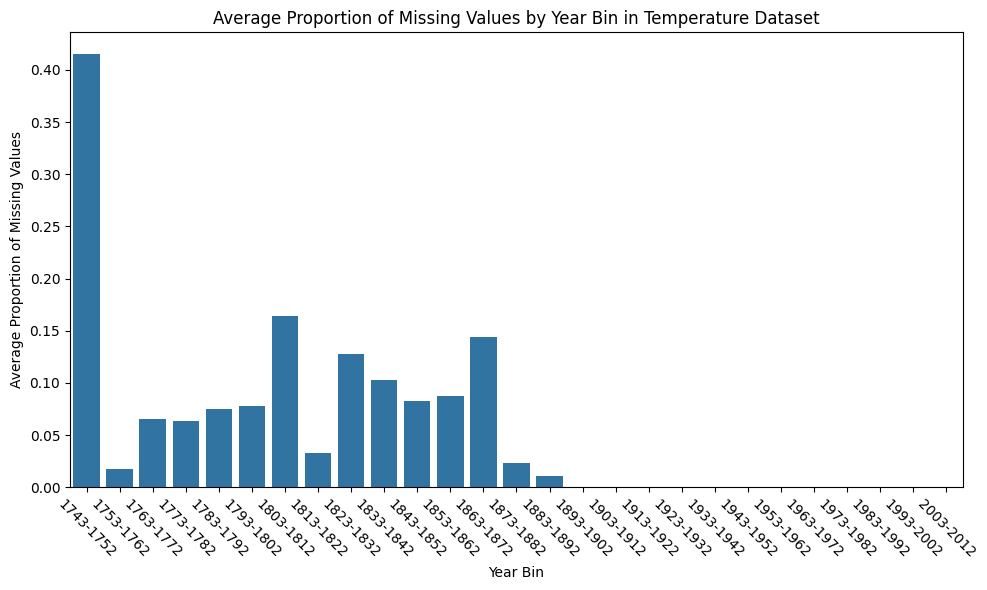

In [20]:
bin_size = 10
min_year_temp = temp_df["Year"].min()
max_year_temp = temp_df["Year"].max()
bins_temp = list(range(int(min_year_temp), int(max_year_temp) + bin_size, bin_size))

bin_labels_temp = [f"{i}-{i + bin_size - 1}" for i in bins_temp[:-1]]
temp_df["Year_Bin"] = pd.cut(temp_df["Year"], bins=bins_temp, labels=bin_labels_temp, right=False)
temp_missing_by_bin = temp_df.groupby("Year_Bin", observed=True)["Temperature"].apply(lambda x: x.isnull().mean())

temp_missing_df = temp_missing_by_bin.reset_index()
temp_missing_df.columns = ['Year_Bin', 'Missing_Proportion']

plt.figure(figsize=(10, 6))
sns.barplot(x="Year_Bin", y="Missing_Proportion", data=temp_missing_df)
plt.xticks(rotation=-45)
plt.title('Average Proportion of Missing Values by Year Bin in Temperature Dataset')
plt.ylabel('Average Proportion of Missing Values')
plt.xlabel('Year Bin')
plt.tight_layout()
plt.show()

From this visualization, we can see that most missing values are from about 1900 and earlier. This supports our hypothesis that the missing values are unavailable from an earlier period for some countries and not due to being missing at random or due to data corruption. To further evaluate this, we can check the count of missing values from 1900 onwards. 

We see that there are no missing temperature values from 1900 onwards. Since our main question related to this project is about pesticide use and it's respective dataset only has data from 2016, we can safely remove these datasets by subsetting the data from 1900 onwards. 

In [16]:
temp_df[temp_df["Year"] >= 1900].isnull().sum()

Year             0
Country          0
Temperature      0
Year_Bin       345
dtype: int64

In [17]:
temp_df_cleaned = temp_df[temp_df["Year"] >= 1900].copy().reset_index()
temp_df_cleaned = temp_df_cleaned.drop(columns=['Year_Bin'])

#### Rainfall

From the following visualization We can see that the missing values are almost perfectly distributed among all the years, suggesting that they may just be missing at random rather than unavailable or due to some other pattern. However, we should do a similar analysis grouping by country to see if values are missing for specific countries. Based on this, only a few countries may be missing values. Let's analyze this to see which ones might be the culprits here. The value of 31

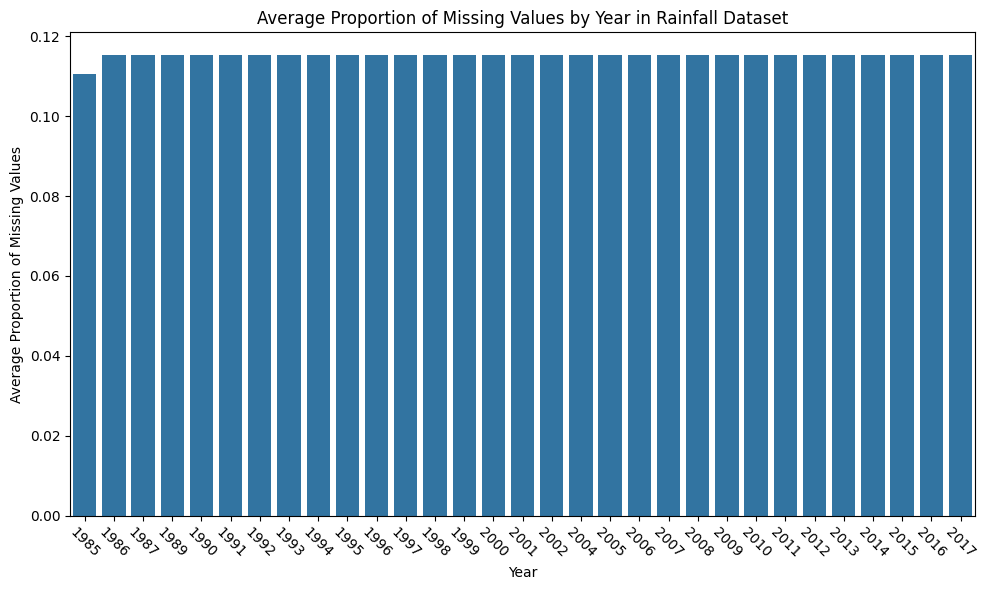

In [24]:
bin_size = 5
min_year_rainfall = rain_df["Year"].min()
max_year_rainfall = rain_df["Year"].max()
bins_rainfall = list(range(int(min_year_rainfall), int(max_year_rainfall) + bin_size, bin_size))
bin_labels_rainfall = [f"{i}-{i + bin_size - 1}" for i in bins_rainfall[:-1]]

plt.figure(figsize=(10, 6))
sns.barplot(x="Year", y="Missing_Proportion", data=rainfall_missing_by_year)
plt.xticks(rotation=-45)
plt.title('Average Proportion of Missing Values by Year in Rainfall Dataset')
plt.ylabel('Average Proportion of Missing Values')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

##### Countries with missing rainfall data:
Okay, we can see that only certain countries are missing values, which is interesting. Let's see what this looks like if we graph it.

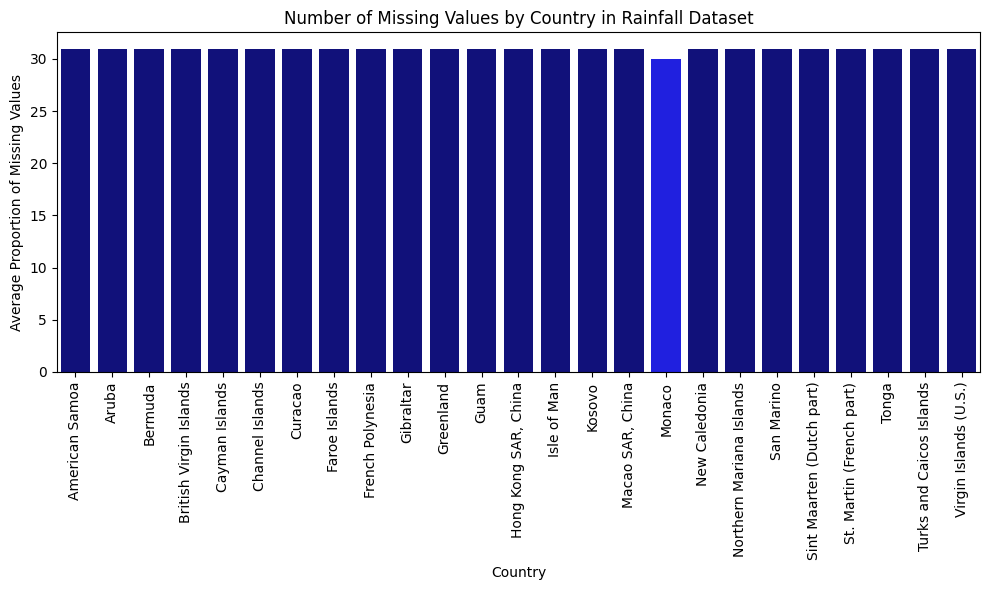

In [37]:
rainfall_missing_by_country = rain_df.groupby('Country')['Rainfall'].apply(lambda x: x.isnull().sum()).reset_index()
rainfall_missing_by_country.columns = ['Country', 'Missing_Count']

rainfall_missing_by_country = rainfall_missing_by_country[rainfall_missing_by_country["Missing_Count"] > 0]
rainfall_missing_by_country['Is_Monaco'] = rainfall_missing_by_country['Country'] == 'Monaco'

plt.figure(figsize=(10, 6))
palette = {True: 'blue', False: 'darkblue'}  # Color for Monaco and other countries
sns.barplot(x="Country", y="Missing_Count", data=rainfall_missing_by_country, hue='Is_Monaco', dodge=False, palette=palette)
plt.xticks(rotation=90)
plt.title('Number of Missing Values by Country in Rainfall Dataset')
plt.ylabel('Average Proportion of Missing Values')
plt.xlabel('Country')
plt.legend().remove()  # Remove the legend since it's not necessary
plt.tight_layout()
plt.show()

This shows that the countries missing values all have 31 missing values, except Monaco, why 30 here? It appears that Monaco has an errant value of `..` for a single row. There are only 31 unique values for the year column, so it seem that the missing values are concentrated in the list of countries from above and there are no values for these countries. Since they are systematically missing, we could either impute them by finding supplemental data, using averages for similar countries, or we could drop these values from our dataset. 

#### Monaco:

In [45]:
rain_df[rain_df['Country'] == 'Monaco']['Rainfall'].value_counts()

Rainfall
..    1
Name: count, dtype: int64

#### Countries missing rainfall data:

If we look at the some statistics of these countries, we can filter the pesticide data based on the countries that are missing rainfall data, then compare the distributions or means of this subset with the overall pesticide dataset. 

In [70]:
rain_df[rain_df["Rainfall"].isna()]["Country"].unique()

array(['American Samoa', 'Aruba', 'Bermuda', 'British Virgin Islands',
       'Cayman Islands', 'Channel Islands', 'Curacao', 'Faroe Islands',
       'French Polynesia', 'Gibraltar', 'Greenland', 'Guam',
       'Hong Kong SAR, China', 'Isle of Man', 'Kosovo',
       'Macao SAR, China', 'Monaco', 'New Caledonia',
       'Northern Mariana Islands', 'San Marino',
       'Sint Maarten (Dutch part)', 'St. Martin (French part)', 'Tonga',
       'Turks and Caicos Islands', 'Virgin Islands (U.S.)'], dtype=object)

#### Filter the pesticides data based on the countries missing rainfall data:

In [77]:
pest_mean = pest_df['Pesticides'].mean().round(0).astype(int)
subset_mean = subset_pest_df['Pesticides'].mean().round(0).astype(int)

print(f'Mean pesticides of those missing rainfall data: {subset_mean}')
print(f'Mean pesticides of data overall: {pest_mean}')

Mean pesticides of those missing rainfall data: 25
Mean pesticides of data overall: 6569


#### Visual comparison:

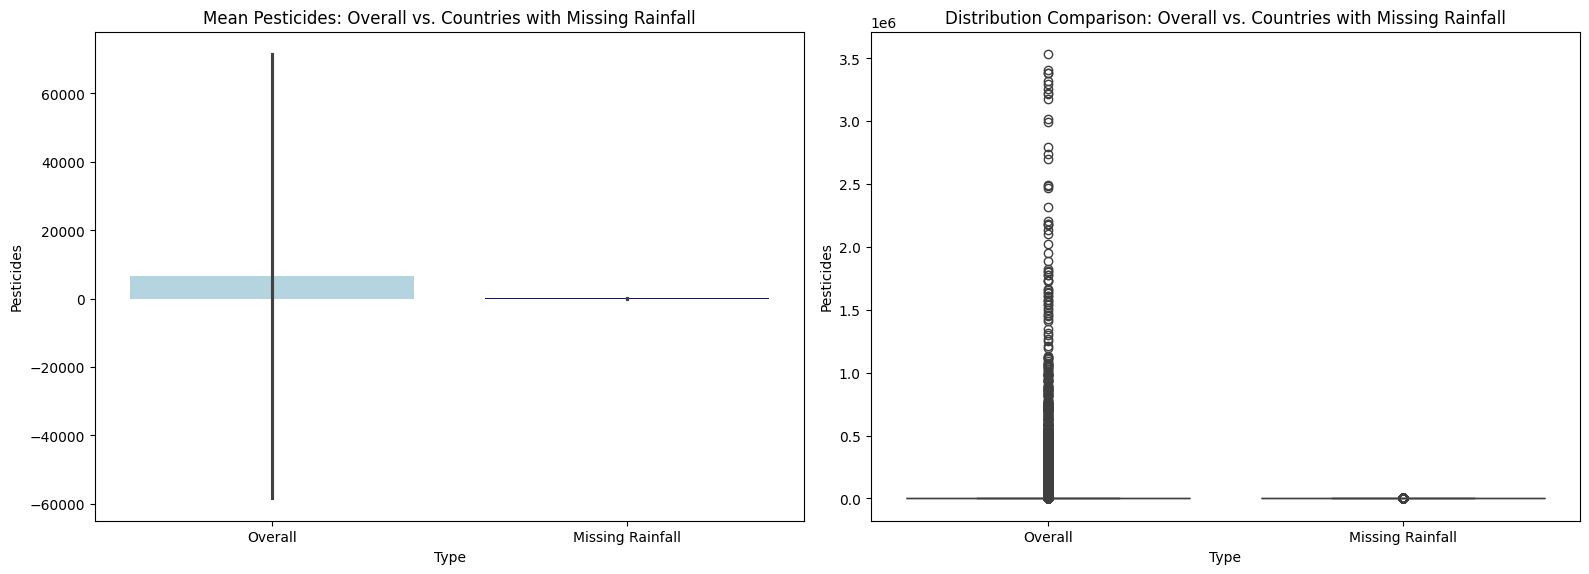

In [72]:
countries_with_missing_rainfall = rain_df[rain_df["Rainfall"].isna()]["Country"].unique()
subset_pest_df = pest_df[pest_df["Country"].isin(countries_with_missing_rainfall)]
df_overall = pest_df[['Pesticides']].copy()
df_overall['Type'] = 'Overall'
df_missing_rainfall = subset_pest_df[['Pesticides']].copy()
df_missing_rainfall['Type'] = 'Missing Rainfall'
df_combined = pd.concat([df_overall, df_missing_rainfall])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='Type', y='Pesticides', data=df_combined, palette=palette_colors, ci='sd', estimator=np.mean, ax=axes[0])
axes[0].set_title('Mean Pesticides: Overall vs. Countries with Missing Rainfall')

sns.boxplot(x='Type', y='Pesticides', data=df_combined, ax=axes[1])
axes[1].set_title('Distribution Comparison: Overall vs. Countries with Missing Rainfall')

plt.tight_layout()
plt.show()

### Remove these countries from rainfall data set

In [44]:
rain_df_cleaned = rain_df[~rain_df["Country"].isin(countries_with_missing_rainfall)].copy().reset_index()
rain_df_cleaned.isnull().sum()

index       0
Country     0
Year        0
Rainfall    0
dtype: int64

### Confirm we have taken care of missing values
Now, let's revisit our 4 datasets and check that we have addressed missing values.

In [32]:
print("Missing values in temp_df:", temp_df_cleaned.isna().sum().sum())
print("Missing values in rain_df:", rain_df_cleaned.isna().sum().sum())
print("Missing values in pest_df:", pest_df.isna().sum().sum())
print("Missing values in yield_df:", yield_df.isna().sum().sum())

Missing values in temp_df: 0
Missing values in rain_df: 0
Missing values in pest_df: 0
Missing values in yield_df: 0


### Data Types

The rainfall data has numeric rainfall has mixed data in the Rainfall column, so we have to convert this to numeric.

In [33]:
rain_df.dtypes

Country     object
Year         int64
Rainfall    object
dtype: object

In [79]:
rain_df_cleaned['Rainfall'] = rain_df_cleaned['Rainfall'].astype(str)
non_numeric_rain = rain_df_cleaned[~rain_df_cleaned['Rainfall'].str.isnumeric()]

The rainfall data has `..` values we need to deal with. Since these Countries already have values in the other rows, we can just impute these values with those values. The rainfall dataset has only 217 unique values for the amount of rainfall and on closer inspection it appears that rainfall is the same value each year for each country. This makes it easy to impute the value, but it complicates part of our analysis since this dataset won't give us any information or insight into how yields may have changed over time with respect to changes in rainfall. Although, we can still see if there may be some degree of correlation between amount of rainfall and yield.

In [85]:
print(rain_df_cleaned[rain_df_cleaned['Rainfall'] == '..'])
rain_df_cleaned.loc[(rain_df_cleaned['Country'] == 'Bahamas') & (rain_df_cleaned['Rainfall'] == '..'), 'Rainfall'] = 1292
rain_df_cleaned['Rainfall'] = rain_df_cleaned['Rainfall'].astype(float)
rain_df_cleaned[rain_df_cleaned['Country'] == 'Bahamas'].describe()

Empty DataFrame
Columns: [index, Country, Year, Rainfall]
Index: []


,index,Year,Rainfall
count,31.000000,31.000000,31.0
mean,418.000000,2001.354839,1292.0
std,9.092121,9.686927,0.0
min,403.000000,1985.000000,1292.0
25%,410.500000,1993.500000,1292.0
50%,418.000000,2001.000000,1292.0
75%,425.500000,2009.500000,1292.0
max,433.000000,2017.000000,1292.0







# TODO
-
-
-
-
-
-
-
-
#### Duplicate Values

In [87]:
temp_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39330 entries, 0 to 39329
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        39330 non-null  int64  
 1   Year         39330 non-null  int64  
 2   Country      39330 non-null  object 
 3   Temperature  39330 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [41]:
year_ranges()

Year range in temp.csv 1743 - 2013
Year range in rainfall.csv 1985 - 2017
Year range in yield.csv 1961 - 2021
Year range in pesticides.csv 1990 - 2021


In [42]:
temp_df_cleaned.nunique()

index          39330
Year             114
Country          137
Temperature     3118
dtype: int64

In [43]:
display(Markdown('##### Number of rows for select countries'))
print('United Kingdom:', temp_df_cleaned[temp_df_cleaned['Country'] == 'United Kingdom'].shape[0])
print('United States: ', temp_df_cleaned[temp_df_cleaned['Country'] == 'United States'].shape[0])
print('Bahamas: ',temp_df_cleaned[temp_df_cleaned['Country'] == 'Bahamas'].shape[0])
print('Bahamas unique: ', temp_df_cleaned[temp_df_cleaned['Country'] == 'Bahamas']['Year'].nunique())

##### Number of rows for select countries

United Kingdom: 570
United States:  5928
Bahamas:  114
Bahamas unique:  114


We can see that there are 114 rows for Bahamas and 114 unique years, indicating a single value per year for the Bahamas. However, if we look at other countries such as the United States or United Kingdom, there are many more rows than we would expect if there were just a single value for each year. 

If we produce a dataframe of duplicate counts, we can see that counts vary by country and year over time, with counts increasing over time. If we consider the United States, it goes from 22 up to 52. This suggests that the temp.csv file is missing information. Could these 52 values for the last 165 years represent the states, Puerto Rico, and Guam? This can complicate how we move forward with merging the data.

In [45]:
duplicate_counts_temp = temp_df.groupby(['Year', 'Country']).size().reset_index(name='Count')
duplicate_counts_temp = duplicate_counts_temp[duplicate_counts_temp['Count'] > 1]
duplicate_counts_temp.sort_values(by='Count', ascending=False).head(10)

,Year,Country,Count
27137,2003,United States,52
26589,1999,United States,52
14533,1911,United States,52
8937,1870,United States,52
11108,1886,United States,52
13985,1907,United States,52
24945,1987,United States,52
17547,1933,United States,52
19191,1945,United States,52
23986,1980,United States,52


In [46]:
top_countries = duplicate_counts_temp.groupby('Country')['Count'].sum().nlargest(7).index.tolist()

filtered_data = duplicate_counts_temp[duplicate_counts_temp['Country'].isin(top_countries)]

chart = alt.Chart(filtered_data).mark_line().encode(
    x='Year',
    y='Count',
    color='Country',
    tooltip=['Year', 'Count', 'Country']
).properties(
    title='Duplicate Counts by Year for Top 7 Countries',
    width=600,
    height=300
)

chart

alt.Chart(...)

From this chart we can see that there a few countries with multiple duplicates per year consistently over time. Given that these are larger countries, these temperature values may represent different geographical areas within the country. Again, this can add some complication to our analysis given the missing information.

#### Todo 

deal with duplicates

#### Yield
The dataset do not contain any missing values in any of its columns. This makes the data cleaning process easier.

### Todo

### Negative values

todo

# Narrow focus

Remove countries that have duplicate values, focus on medium to smaller countries, a specific contiennt, area?
Find data on population? 

# Merge

In [48]:
merged_yield_pesticides = yield_df.merge(pest_df, on=['Country', 'Year'], how='inner').reset_index(drop=True)
merged_temp = merged_yield_pesticides.merge(temp_df_cleaned, on=['Country', 'Year'], how='inner').reset_index(drop=True)
merged_df = merged_temp.merge(rain_df_cleaned, on=['Country', 'Year'], how='inner').reset_index(drop=True)
merged_df.drop(columns=['index_x', 'index_y'], errors='ignore', inplace=True)

merged_df

,Country,Year,Yield,Pesticides,Temperature,Rainfall
0,Albania,1990,4368200.0,121.00,16.37,1485.0
1,Albania,1990,4368200.0,0.17,16.37,1485.0
2,Albania,1990,4368200.0,0.04,16.37,1485.0
3,Albania,1990,4368200.0,0.12,16.37,1485.0
4,Albania,1990,4368200.0,70.00,16.37,1485.0
...,...,...,...,...,...,...
83353,Zimbabwe,2013,5208664.0,0.00,19.76,657.0
83354,Zimbabwe,2013,5208664.0,177.70,19.76,657.0
83355,Zimbabwe,2013,5208664.0,0.00,19.76,657.0
83356,Zimbabwe,2013,5208664.0,0.00,19.76,657.0


In [49]:
merged_yield_pesticides

,Country,Year,Yield,Pesticides
0,Africa,1990,8429785.0,73958.66
1,Africa,1990,8429785.0,0.36
2,Africa,1990,8429785.0,0.12
3,Africa,1990,8429785.0,0.49
4,Africa,1990,8429785.0,25495.31
...,...,...,...,...
102703,Zimbabwe,2021,5086704.0,0.41
102704,Zimbabwe,2021,5086704.0,7.24
102705,Zimbabwe,2021,5086704.0,133.40
102706,Zimbabwe,2021,5086704.0,0.00


In [50]:
merged_yield_pesticides.isna().sum()

Country       0
Year          0
Yield         0
Pesticides    0
dtype: int64

In [51]:
merged_df.to_csv('merged_df.csv', index=False)

Todo: make a notation of the units for the merged_df

### Segway into finding countries that have reduced pesticide use

Reasoning behind

In [83]:
aggregated_data = merged_df.groupby(['Country', 'Year']).agg({
    'Yield': 'first',
    'Pesticides': 'mean',
    'Temperature': 'first',
    'Rainfall': 'first'
}).reset_index()

aggregated_data.head()

,Country,Year,Yield,Pesticides,Temperature,Rainfall
0,Albania,1990,4368200.0,20.194167,16.37,1485.0
1,Albania,1991,5665042.0,20.195833,15.36,1485.0
2,Albania,1992,5960509.0,20.194167,16.06,1485.0
3,Albania,1993,6008588.0,11.353750,16.05,1485.0
4,Albania,1994,6585554.0,18.860000,16.96,1485.0


In [89]:
aggregated_data[aggregated_data['Country'] == 'Sudan']

,Country,Year,Yield,Pesticides,Temperature,Rainfall
2167,Sudan,2012,6196866.0,205.327222,26.42,1712.0
2168,Sudan,2013,6155692.0,410.136154,26.84,1712.0


In [91]:
aggregated_data.describe(include='all')

,Country,Year,Yield,Pesticides,Temperature,Rainfall
count,2418,2418.000000,2.418000e+03,2418.000000,2418.000000,2418.000000
unique,109,NaN,NaN,NaN,NaN,NaN
top,Albania,NaN,NaN,NaN,NaN,NaN
freq,23,NaN,NaN,NaN,NaN,NaN
mean,NaN,2001.652192,6.143327e+06,2722.432615,18.680910,1094.500827
std,NaN,7.016987,4.325602e+06,7788.289287,7.655318,746.640304
min,NaN,1990.000000,3.431160e+05,0.132857,-3.370000,51.000000
25%,NaN,1996.000000,3.040288e+06,57.482401,11.227500,589.000000
50%,NaN,2001.000000,5.311394e+06,320.126299,19.970000,867.000000
75%,NaN,2008.000000,8.488201e+06,1438.747361,25.957500,1537.000000


In [92]:
aggregated_data['Country'].value_counts()

Country
Albania       23
Mexico        23
Nigeria       23
Niger         23
Nicaragua     23
              ..
Eritrea       20
Belgium       13
Serbia         8
Montenegro     8
Sudan          2
Name: count, Length: 109, dtype: int64

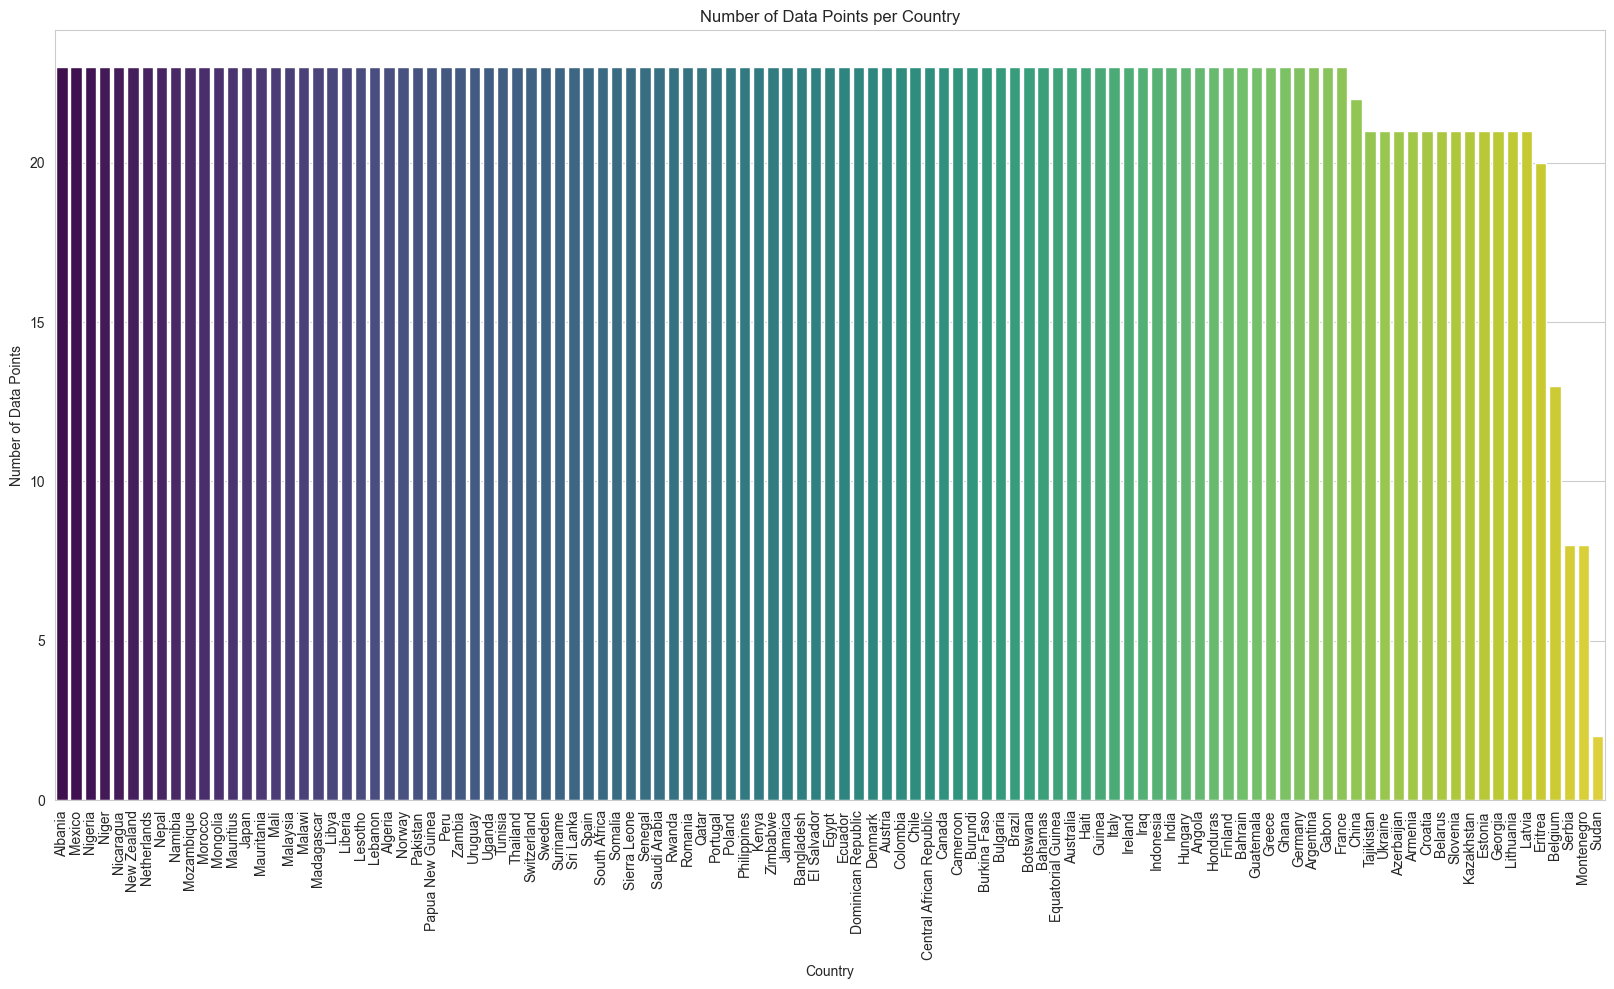

In [93]:
country_data_points(aggregated_data)

In [136]:
countries_with_few_data = aggregated_data['Country'].value_counts()
selected_countries = countries_with_few_data[countries_with_few_data < 14].index.tolist()
selected_countries

['Belgium', 'Serbia', 'Montenegro', 'Sudan']

In [126]:
set(ranking_df['Country'].tolist()) & set(selected_countries)

{'Belgium', 'Croatia', 'Kazakhstan', 'Tajikistan'}

In [128]:
merged_df[merged_df['Country'] == 'Sudan']

,Country,Year,Yield,Pesticides,Temperature,Rainfall
78436,Sudan,2012,6196866.0,2469.47,26.42,1712.0
78437,Sudan,2012,6196866.0,2469.47,29.96,1712.0
78438,Sudan,2012,6196866.0,0.12,26.42,1712.0
78439,Sudan,2012,6196866.0,0.12,29.96,1712.0
78440,Sudan,2012,6196866.0,0.07,26.42,1712.0
...,...,...,...,...,...,...
78529,Sudan,2013,6155692.0,28.90,30.65,1712.0
78530,Sudan,2013,6155692.0,3.01,26.84,1712.0
78531,Sudan,2013,6155692.0,3.01,30.65,1712.0
78532,Sudan,2013,6155692.0,0.00,26.84,1712.0


In [135]:
temp_df[temp_df['Country'] == 'Sudan'].isna().sum()

Year            0
Country         0
Temperature    23
Year_Bin        2
dtype: int64

In [131]:
def det(df, country):
    return print(df[df['Country'] == country])

In [134]:
det(yield_df,'Sudan')

      Country  Year      Yield
11535   Sudan  2012  6196866.0
11536   Sudan  2013  6155692.0
11537   Sudan  2014  5833167.0
11538   Sudan  2015  5516545.0
11539   Sudan  2016  5087762.0
11540   Sudan  2017  5231417.0
11541   Sudan  2018  5351141.0
11542   Sudan  2019  5272099.0
11543   Sudan  2020  5275498.0
11544   Sudan  2021  5195825.0
